## Exploration_16_SRGAN
1. 데이터 준비
2. Bilinear, Bicubic, HR 비교
3. SRCNN 
4. SRGAN 
5. PSNR, SSIM 측정
6. SRCNN vs. SRGAN
7. 고해상도 GIF 만들기
8. 회고

### 1. 데이터 준비

(571, 637, 3)


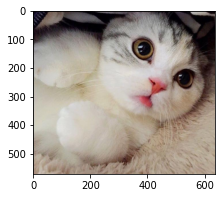

In [102]:
from skimage import data
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf

img_path = os.getenv('HOME')+'/aiffel/super_resolution/kitty.jpg'
img_orig = cv2.imread(img_path)
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
print(img_orig.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(6,3))
plt.imshow(img_orig)

* 고양이 이미지를 하나 가져온다.

(142, 159, 3)


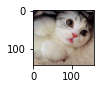

In [103]:
lr_image = cv2.resize(img_orig, dsize=(637//4, 571//4)) # size down to 1/4

print(lr_image.shape)

plt.figure(figsize=(3,1))
plt.imshow(lr_image)

* 먼저 1/4 로 사이즈를 줄인다.

### 2. Bilinear, Bicubic, HR 비교

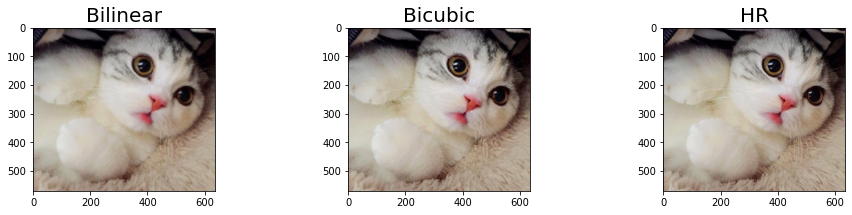

In [104]:
bilinear_image = cv2.resize(
    lr_image, 
    dsize=(637, 571), # (가로 픽셀 수, 세로 픽셀 수) 
    interpolation=cv2.INTER_LINEAR # bilinear interpolation 적용
)

bicubic_image = cv2.resize(
    lr_image, 
    dsize=(637, 571), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [bilinear_image, bicubic_image, img_orig]
titles = ["Bilinear", "Bicubic", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

* 그리고 bilinear, bicubic 을 적용하여 다시 사이즈를 키운 뒤, HR과 함께 선명도를 비교 해본다.
* 이정도 사이즈에서는 큰 차이를 못 느낀다. 따라서 일부 부분을 잘라서 비교 해보기로 한다.

#### 확대 비교

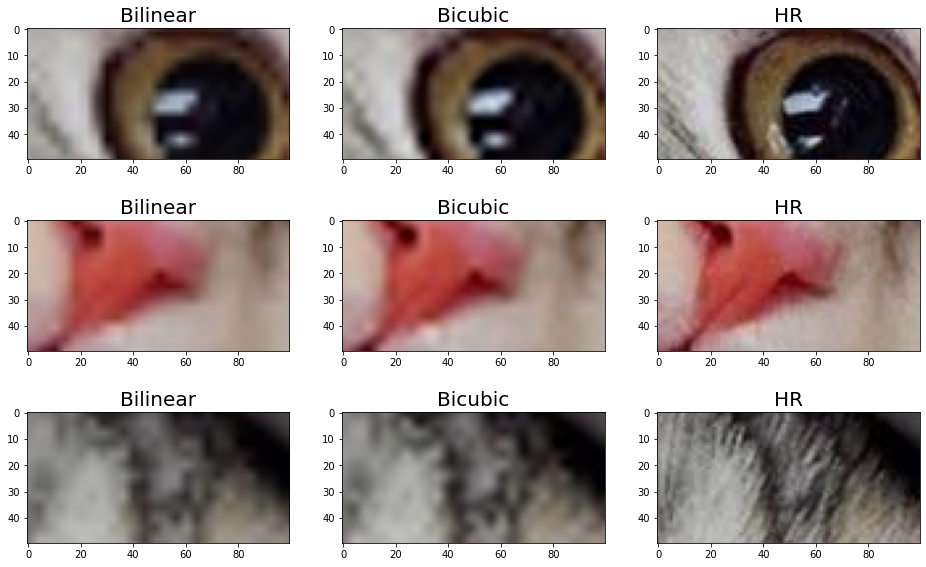

In [111]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(100,320)] *3 + [(250,400)] *3 + [(50,450)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

* 결과 적으로 여전히 두 방법 모두 HR대비 해상도가 많이 낮은 것을 알 수 있다.
* 냥이 눈이 너무 무섭다..

### 3. SRCNN

#### 데이터 준비하기

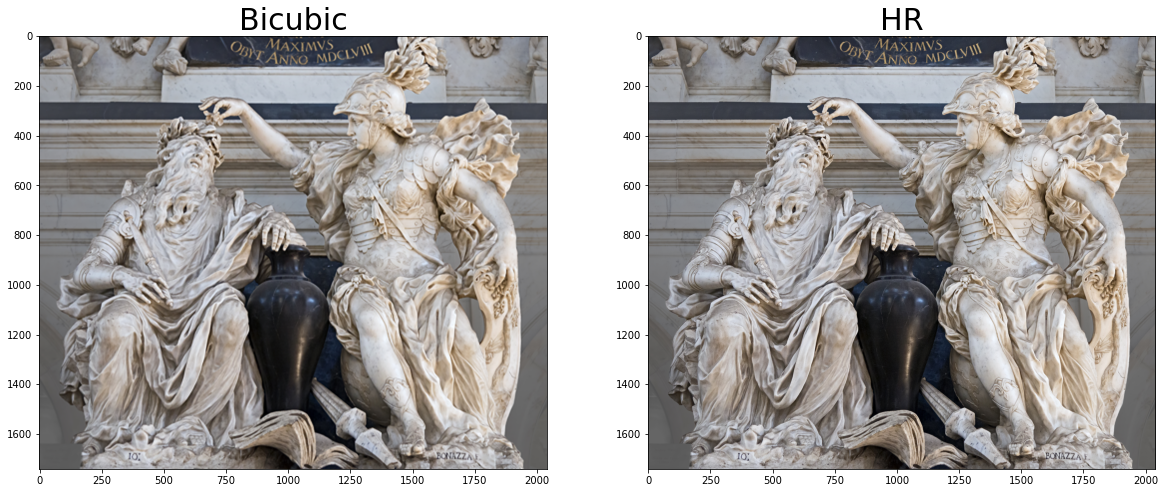

In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# 데이터를 불러옵니다.
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

# 시각화를 위해 한 개의 데이터만 선택합니다.
for i, (lr, hr) in enumerate(valid):
    if i == 6: break
    
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.  
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
    lr, 
    dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 저해상도 및 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Bicubic', fontsize=30)
plt.imshow(bicubic_hr)

plt.subplot(1,2,2)
plt.title('HR', fontsize=30)
plt.imshow(hr)

* 학습에 사용 될 임의의 이미지 하나를 불러와서 'Bicubic', 'HR'이 적용된 상태의 해상도를 비교 해 본다.
* 원래는 좀 더 효율적인 학습을 위해서 '고양이'와 비슷한 '사자' 이미지를 가져와 진행을 했었지만, 자꾸 오류가 발생해서 부득이하게 노드에서 사용한 이미지를 가져와 진행하였다 (index = 39 였던가.. 사자 이미지가 있었다).
* 큰 사진으로는 특별한 차이가 보이지 않기 때문에 부분적으로 확대하여 비교해 보도록 한다.

#### 이미지 확대 비교

Text(0.5, 1.0, 'HR')

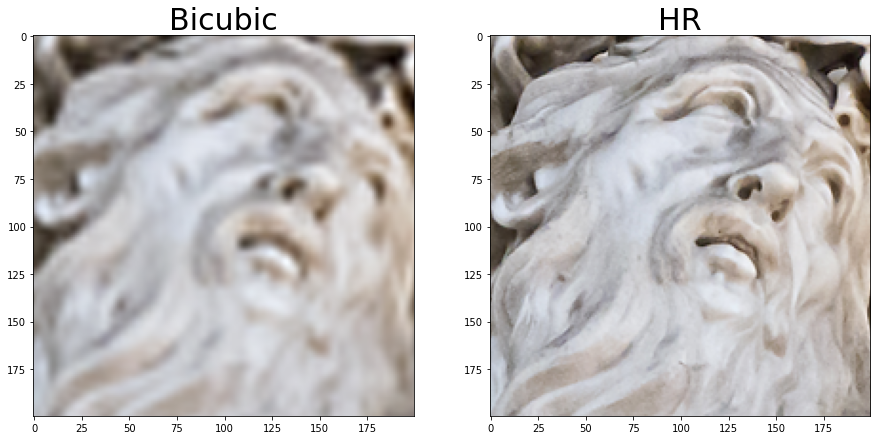

In [76]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (400, 500)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_hr = crop(hr, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title("HR", fontsize=30)

* 사진의 일부 위치를 확대하여 비교 해 본 결과 확실히 Bicubic이 적용 된 이미지의 해상도가 낮은 것을 알 수 있다.
* 따라서 SRCNN을 이용해서 해상도를 개선 해 보고자 한다.

#### Test, Validation set 구성

In [77]:
import tensorflow as tf

def preprocessing(lr, hr):
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr = tf.image.random_crop(hr, size=[96, 96, 3])
    hr = tf.cast(hr, tf.float32) / 255.
    
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
    # interpolation을 이용해 다시 원래 크기로 되돌립니다.
    # 이렇게 만든 저해상도 이미지를 입력으로 사용합니다.
    lr = tf.image.resize(hr, [96//4, 96//4], "bicubic")
    lr = tf.image.resize(lr, [96, 96], "bicubic")
    return lr, hr

train = train.map(preprocessing).shuffle(buffer_size=10).batch(16)
valid = valid.map(preprocessing).batch(16)

#### 모델구현

In [78]:
from tensorflow.keras import layers, Sequential

# 3개의 convolutional layer를 갖는 Sequential 모델을 구성합니다.
srcnn = Sequential()
# 9x9 크기의 필터를 128개 사용합니다.
srcnn.add(layers.Conv2D(128, 9, padding="same", input_shape=(None, None, 3)))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(64, 5, padding="same"))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(3, 5, padding="same"))

srcnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, None, None, 128)   31232     
_________________________________________________________________
re_lu_2 (ReLU)               (None, None, None, 128)   0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, None, None, 64)    204864    
_________________________________________________________________
re_lu_3 (ReLU)               (None, None, None, 64)    0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, None, None, 3)     4803      
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


#### 학습시작

In [79]:
srcnn.compile(
    optimizer="adam", 
    loss="mse"
)

srcnn.fit(train, validation_data=valid, epochs=10)

Epoch 1/10
50/50 [==============================] - 26s 479ms/step - loss: 0.0461 - val_loss: 0.0080
Epoch 2/10
50/50 [==============================] - 25s 475ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 3/10
50/50 [==============================] - 25s 475ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 4/10
50/50 [==============================] - 25s 476ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 5/10
50/50 [==============================] - 25s 478ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 6/10
50/50 [==============================] - 25s 474ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 7/10
50/50 [==============================] - 25s 475ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 8/10
50/50 [==============================] - 25s 473ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 9/10
50/50 [==============================] - 25s 482ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 10/10
50/50 [==============================] - 25s 474ms/step - loss: 0.0046 - val_lo

In [80]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

#### SRCNN 적용

In [81]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

srcnn_hr = apply_srcnn(bicubic_image)

#### 이미지 확대 비교

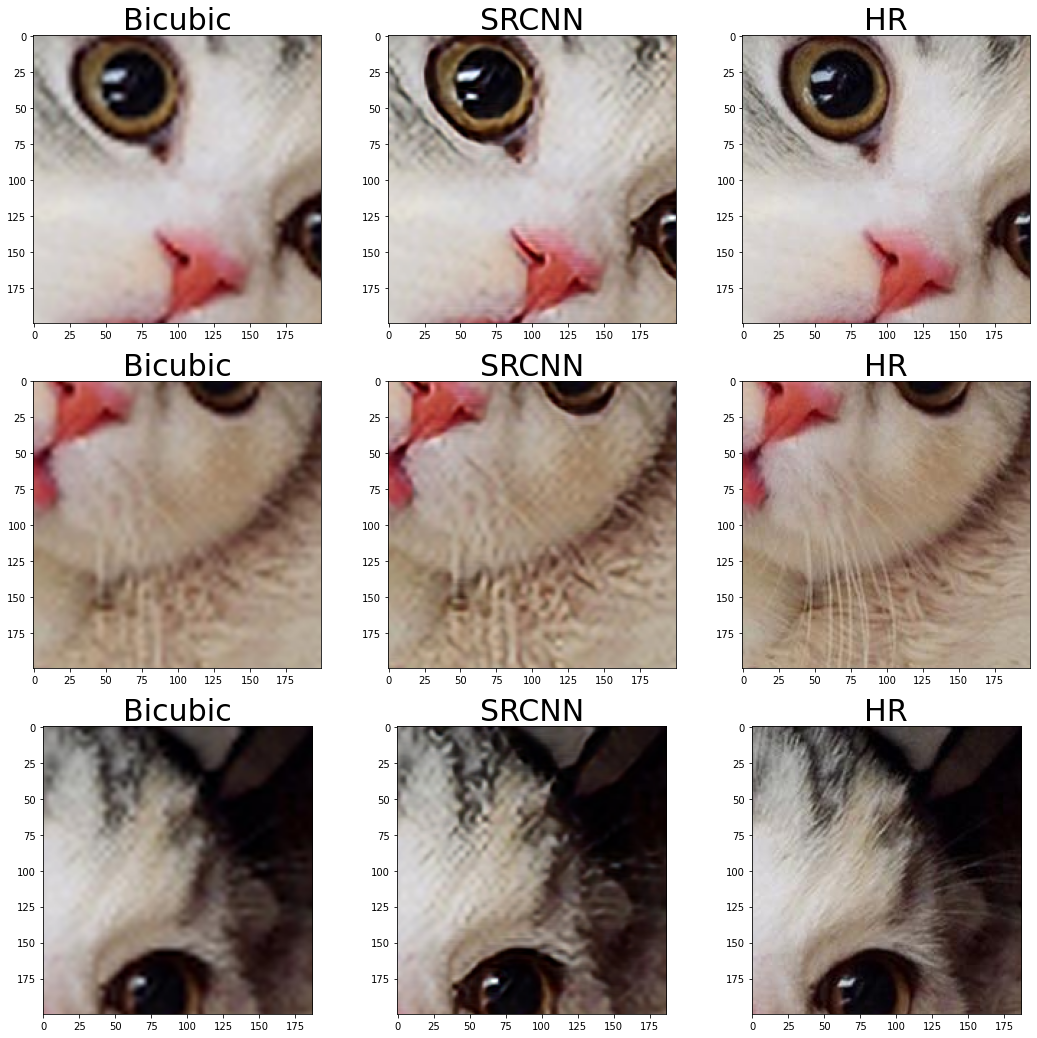

In [82]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(100,320), (250,400), (50,450)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_image, left_top, 200, 200)
    img2 = crop(srcnn_hr , left_top, 200, 200)
    img3 = crop(img_orig, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRCNN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

* SRCNN 학습 시 EPOCHS를 1, 10, 20 정도 설정하고 테스트를 진행 해 본 결과 10 이상 설정해도 큰 차이가 없었기 때문에 더 이상 진행하지는 않았다.
* SRCNN을 사용 한 결과를 보면 Bicubic 보다는 선명도가 조금 올라간 것을 알 수 있지만, 여전히 HR 대비 해상도가 많이 떨어지는 것을 볼 수 있다.
* 따라서 SRCNN 외의 다른 방식이 필요하다고 생각되며 여기서는 SRGAN을 이용 해 보도록 한다.

### 4. SRGAN

#### 데이터 준비

In [83]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
valid = valid.map(preprocessing).repeat().batch(8)

#### Generator Netwrok 구현

**[모식도]**
![](https://d3s0tskafalll9.cloudfront.net/media/images/e-22-17.srgan_gene.max-800x600.png)
- k: kernel size
- n: number of filters
- s: strides

**[코드]**

In [84]:
from tensorflow.keras import Input, Model, layers

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

#### Discriminator Network 구현

**[모식도]**
![](https://d3s0tskafalll9.cloudfront.net/media/images/e-22-18.srgan_disc.max-800x600.png)

#### [코드]

In [85]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

#### VGG19를 이용한 content loss 구하기

In [86]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

#### SRGAN 학습하기

In [87]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()

EPOCH[1] - STEP[10] 
Generator_loss:0.0010 
Discriminator_loss:1.9091

EPOCH[1] - STEP[20] 
Generator_loss:0.0011 
Discriminator_loss:1.4301

EPOCH[1] - STEP[30] 
Generator_loss:0.0015 
Discriminator_loss:1.0821

EPOCH[1] - STEP[40] 
Generator_loss:0.0019 
Discriminator_loss:0.8407

EPOCH[1] - STEP[50] 
Generator_loss:0.0026 
Discriminator_loss:0.6815

EPOCH[1] - STEP[60] 
Generator_loss:0.0030 
Discriminator_loss:0.5755

EPOCH[1] - STEP[70] 
Generator_loss:0.0035 
Discriminator_loss:0.4949

EPOCH[1] - STEP[80] 
Generator_loss:0.0039 
Discriminator_loss:0.4345

EPOCH[1] - STEP[90] 
Generator_loss:0.0042 
Discriminator_loss:0.3872

EPOCH[1] - STEP[100] 
Generator_loss:0.0045 
Discriminator_loss:0.3494

EPOCH[1] - STEP[110] 
Generator_loss:0.0046 
Discriminator_loss:0.3225

EPOCH[1] - STEP[120] 
Generator_loss:0.0047 
Discriminator_loss:0.3004

EPOCH[1] - STEP[130] 
Generator_loss:0.0049 
Discriminator_loss:0.2812

EPOCH[1] - STEP[140] 
Generator_loss:0.0050 
Discriminator_loss:0.2631

E

#### SRGAN 테스트하기

In [88]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [89]:
import numpy as np

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

srgan_hr = apply_srgan(lr_image)

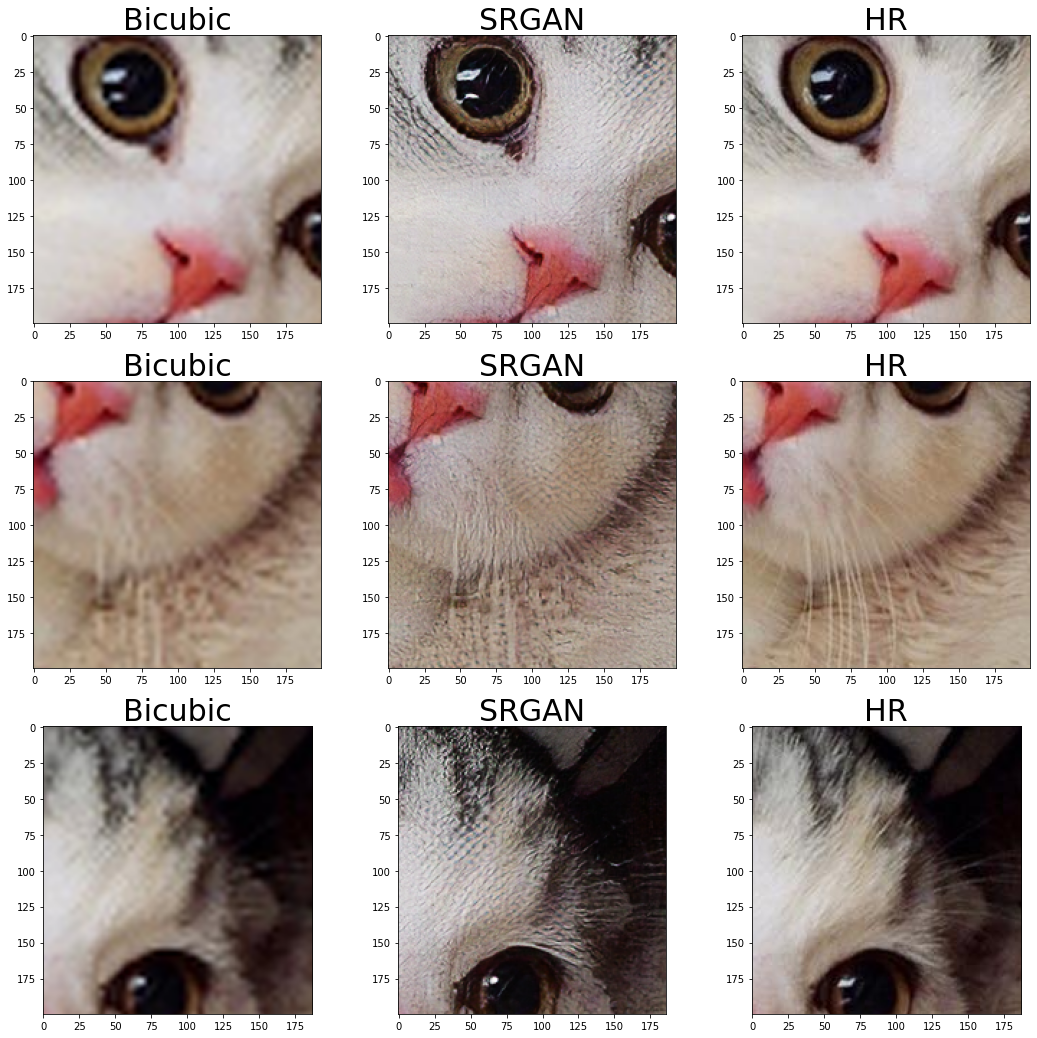

In [90]:
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(100,320), (250,400), (50,450)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_image, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(img_orig, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

# # 전체 이미지 출력, 비교
# full_img = [bicubic_image, srgan_hr, img_orig]
# plt.figure(figsize=(18,6))
# for i in range(3):
#     plt.subplot(1,3,i+1) 
#     plt.imshow(full_img[i])
#     plt.title(labels[i], fontsize=30)

* 부분 이미지를 비교한 결과를 보면 Bicubic이 가장 해상도가 낮고 SRGAN을 사용한 결과는 오히려 HR 보다 피부가 더 선명하게 드러나 보인다. 다시말해 세세한 털에 대한 묘사가 좀 부족한 느낌이다.
* SRGAN 결과는 뭔가 HR에 가깝다기 보다 Bicubic의 결과에서 해상도가 확 올라간 느낌이 강하다.
* 결론적으로 해상도를 올리고자 하던 목표는 달성했지만, HR과는 조금은 다른 결과를 얻게 되었다. 하지만 확대를 하지 않고 전체적인 이미지로 본다면 오히려 HR보다 더 선명해 보이기도 한다.

### 5. PSNR, SSIM 측정
- PSNR(Peak Signal-to-Noise Ratio) : 영상 내 신호가 가질 수 있는 최대신호에 대한 잡음의 비율. 화질 손실비율 평가목적. 값이 높을 수록 손실이 적다는 의미(최대값=infinity).
- SSIM(Structural Similarity Index Map) : 영상의 구조 정보를 얼마나 변화시키지 않았냐, 즉 얼마나 원본 상태를 유지하냐에 대한 측정 값. 값이 높을 수록 원본에 가깝다. 즉, 값이 높을 수록, 최대값 1.0에 가까울 수록, 좋다.

#### 'HR' 이미지에 대한 값 측정

In [91]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

print("**동일 이미지 비교**")
print("PSNR :", peak_signal_noise_ratio(img_orig, img_orig))
print("SSIM :", structural_similarity(img_orig, img_orig, multichannel=True))

**동일 이미지 비교**
PSNR : inf
SSIM : 1.0


* PSNR, SSIM 모두 최대값을 가진다. 즉 손실이 없다.

#### 해상도 1/2, 1/4, 1/8 이미지에 대한 값 측정

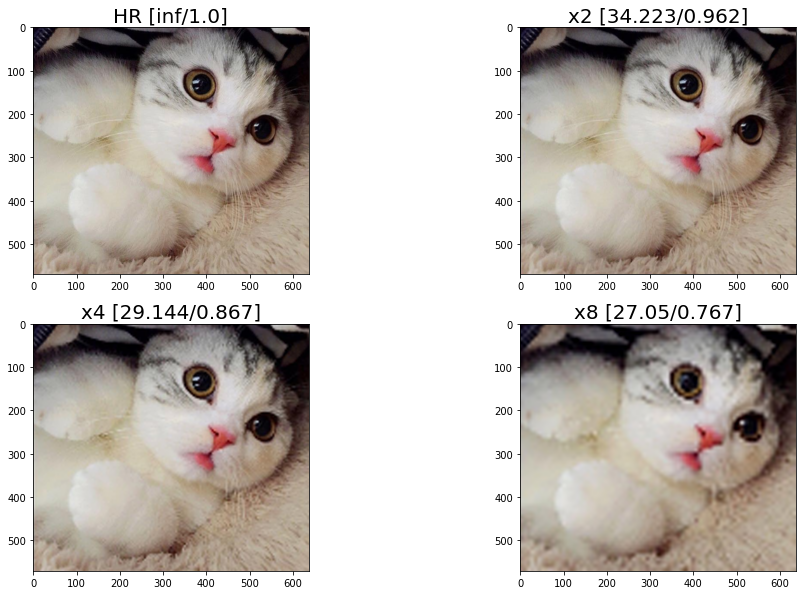

In [92]:

import cv2

# 이미지를 특정 크기로 줄이고 다시 늘리는 과정을 함수로 정의합니다.
def interpolation_xn(image, n):
    downsample = cv2.resize(
        image,
        dsize=(image.shape[1]//n, image.shape[0]//n)
    )
    upsample = cv2.resize(
        downsample,
        dsize=(image.shape[1], image.shape[0]),
        interpolation=cv2.INTER_CUBIC
    )
    return upsample

lr2_cat = interpolation_xn(img_orig, 2) # 1/2로 줄이고 다시 복원
lr4_cat = interpolation_xn(img_orig, 4) # 1/4로 줄이고 다시 복원
lr8_cat = interpolation_xn(img_orig, 8) # 1/8로 줄이고 다시 복원

images = [img_orig, lr2_cat, lr4_cat, lr8_cat]
titles = ["HR", "x2", "x4", "x8"]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(img_orig, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(img_orig, i, multichannel=True), 3) for i in images]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(16,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)

* 해상도가 낮아질 수록 PSNR, SSIM 값이 모두 낮아지는 것을 알 수 있다. 즉 손상 정도가 높아진다.

### 6. SRCNN vs. SRGAN

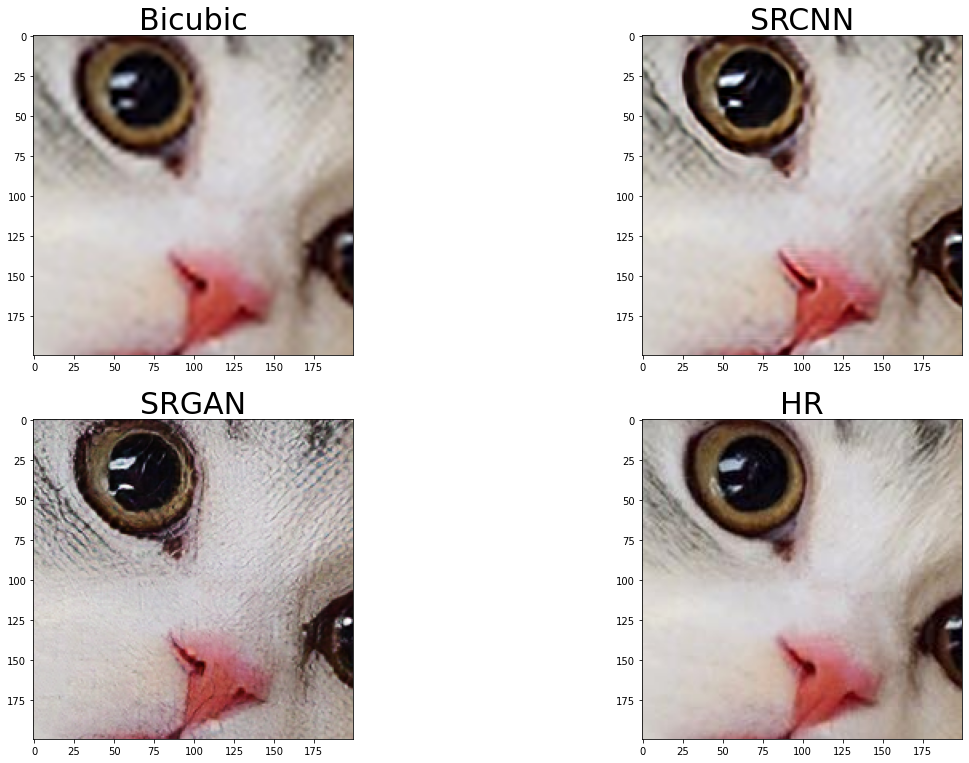

In [93]:
lr_image = cv2.resize(img_orig, dsize=(637//4, 571//4))
lr_img, hr_img = np.array(lr_image), np.array(img_orig)

# bicubic interpolation
bicubic_img = cv2.resize(
    lr_img, 
    (img_orig.shape[1], img_orig.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

# # 전체 이미지를 시각화합니다.
# plt.figure(figsize=(20,15))
# plt.subplot(311); plt.imshow(img_orig)

# SRCNN을 이용해 고해상도로 변환합니다.
srcnn_img = apply_srcnn(bicubic_img)

# SRGAN을 이용해 고해상도로 변환합니다.
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, img_orig]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

left_top = (100, 320) # 잘라낼 부분의 왼쪽 상단 좌표를 지정합니다.

# bicubic, SRCNN, SRGAN 을 적용한 이미지와 원래의 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 200))
    plt.title(titles[i], fontsize=30)

* 순서대로 비교를 해보면, Bicubic -> SRCNN -> SRGAN으로 갈수록 확실히 해상도가 높아지는 것을 알 수 있다.
* SRGAN의 경우 HR과 비교해 보면 오히려 고양이의 피부에 대한 해상도가 훨씬 올라간 것 처럼 보이기도 한다. 따라서 SRGAN이 제대로 작동한다고 볼 수 도 있지만, 달리 보자면 세세한 털에 대한 묘사가 조금 부족하다고 할 수 도 있다.
* 하지만 코 근처의 검은색 수염을 보면 SRGAN에서 확실히 선명하게 보인다.
* 이번 테스트에서 고양이(동물)을 사용하였기에 이런 결과를 얻은 것이라 생각되며, 사물이나 자연환경 등을 사용한 결과에서는 보다 확실한 성능적인 개선을 확인할 수 있지 않을까 생각한다.

### 7. 고해상도 GIF 만들기

#### GIF 불러오기

In [94]:
import cv2

# 저해상도 GIF 불러오기
fire_lr = cv2.VideoCapture(os.getenv('HOME')+'/aiffel/super_resolution/fire_lr.gif')

isTrue = True
frames = []
while isTrue:
    isTrue, frame = fire_lr.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 14
frame 크기 : (282, 300, 3)


#### 출력 확인

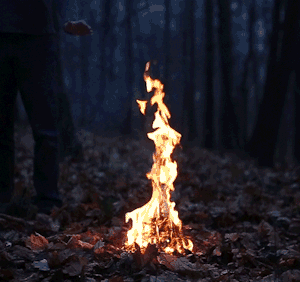

In [112]:
from IPython.display import Image as show_gif
show_gif("fire_lr.gif", width=600)

#### Bicubic 적용

In [96]:
# Bicubic interpolation
frames_bi = []
for frame in frames: # frame을 하나씩 던져서
    frames_bi.append(cv2.resize( # 변경 된 값을 'frames_bi' list에 저장
        frame, 
        (frame.shape[1], frame.shape[0]), 
        interpolation=cv2.INTER_CUBIC
    ))

In [97]:
# GIF 만들기
import imageio
imageio.mimsave("fire_bi.gif", frames_bi)

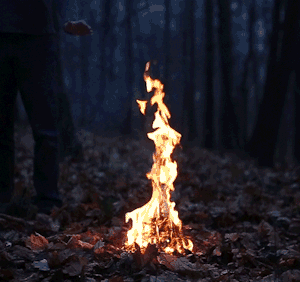

In [98]:
# 결과 출력
from IPython.display import Image as show_gif
show_gif("fire_bi.gif", width=600)

* Bicubic 적용 후 해상도가 조금은 올라간 것 처럼 보이지만, 그 변화가 확 느껴질 정도는 아닌 것 같다.

#### SRGAN 적용

In [99]:
# SRGAN
frames_sr = []
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

for frame in frames: # frame을 하나씩 던져서
    frames_sr.append(apply_srgan(frame))    # 변경 된 값을 'frames_sr' list에 저장

In [100]:
# GIF 만들기
import imageio
imageio.mimsave("fire_sr.gif", frames_sr)

In [113]:
# 결과 출력
from IPython.display import Image as show_gif
show_gif("fire_sr.gif", width=600)

* 한 눈에 봐도 해상도가 상당히 올라간 것을 알 수 있다.
* 불 뿐만아니라 불 안쪽의 장작의 모습까지 매우 선명하게 볼 수 있다.
* 전체적으로 만족스러운 결과를 얻었다.

### 8. 회고

* 이전 노드에서 GAN을 공부하면서 High resolution 이라는 개념에 대해서도 찾아본 적이 있었다. 하지만 이를 실제 구현하는 방법까지는 알지 못했었다.
* 따라서 이번에 SRCNN과 더불이 SRGAN이라는 방법에 대해 알게 되어 개인적으로 꽤나 유익한 노드였다고 할 수 있다.
* 가장 처음 시도한 Bilinear, Bicubic interpolation 방식은 이미지의 해상도 향상에 큰 영향을 주지는 못했다.
* 따라서 추가적으로 SRCNN이라는 방식이 도입 되었고, 이를 이용해 본 결과 기존의 Bi- 방식들에 비해서는 해상도가 올라간 것을 확인 할 수 있었지만 이미지를 확대해서 부분적으로 비교해 보면 HR 이미지 대비 여전히 해상도가 많이 떨어지는 것을 볼 수 있었다.
* SRCNN을 적용하면서 학습시의 EPOCHS를 좀 변경 시켜 봤는데 이에 따른 변화가 생각보다 크지 않았다. 어느정도 변화가 보인다면 다른 parameter들도 좀 바꿔 볼 까 했지만 결과적으로 그렇게까지 해 볼 필요가 없다고 판단하였다.
* SRCNN이 완벽하지 못했기 때문에 더 나은 개선을 목적으로 SR에 GAN이 도입 된 SRGAN 방식이 만들어지게 되었고, 이를 적용해 본 결과 HR에 필적하거나 오히려 부분적으로 HR보다 더 해상도가 높다고 느껴지는 결과를 얻을 수 있었다. 확실히 어떤 이미지를 개선해 나가는 작업에 대해서는 GAN이라는 기술이 상당히 유용하다는 생각이 들었다.
* 이번 과제는 '고양이' 이미지 하나만을 가지고 진행 했지만, 같은 방식으로 건물이나 배경등 다양한 양식의 이미지에 적용해 보면 더욱 더 명확한 해상도 향상의 결과를 얻을 수 있을 것 같다.
* 그리고 마지막으로 앞에서 작성한 여러 기법들을 활용하여 GIF의 선명도를 올리는 과정을 진행 해 봤는데 SRGAN을 사용한 결과가 상당히 만족스러웠다. 한 눈에 봐도 차이점이 확 드러날 정도로 개선이 되는 것이 아주 맘에 들었다. 이 방법은 앞으로 여러모로 사용해 볼 수 도 있을 것 같다.
* 전체적으로 GAN의 또다른 활용방식, 이미지의 resolution을 올리기 위한 다양한 방법들에 대해 알게 된 만족 할 만한 노드였다고 할 수 있겠다.